In [1]:
#importing required Libraries
import numpy as np
import tensorflow
import keras
import os
import pandas as pd
import glob
from skimage import io ,color
import skimage
import random
import cv2
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

## Step 1: Load Dataset

     --------------------- 
       Fruits 360 Dataset 
     --------------------- 
Processing Apples/Apple 10
Processing Apples/Apple 11
Processing Apples/Apple 12
Processing Apples/Apple 13
Processing Apples/Apple 5
Processing Apples/Apple 7
Processing Apples/Apple 8
Processing Apples/Apple 9
Processing Cucumber/Cucumber 1
Processing Cucumber/Cucumber 3
Processing Cucumber/Cucumber 4
Processing Cucumber/Cucumber 5
Processing Cucumber/Cucumber 6
Processing Cucumber/Cucumber 7
Processing Pear/Pear 3
Processing Pear/Pear 5
Processing Pear/Pear 6
Processing Pear/Pear 7
Processing Pear/Pear 8
Processing Pear/Pear 9
----------------------
Data shape: (7986, 64, 64)
Size of Data: 7986
----------------------


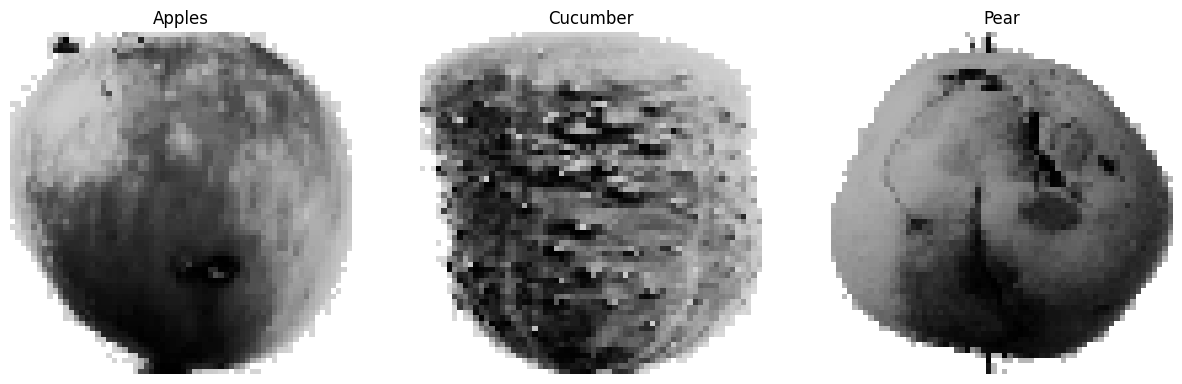

In [2]:
LABELS = {
    "Apples": 0,
    "Cucumber": 1,
    "Pear": 2
}
root_path = r"D:\projects\Project Ai KenKen\DataSetForImages"
IMG_SIZE = (64, 64)

data = []
labels = []
print("     --------------------- ")
print("       Fruits 360 Dataset ")
print("     --------------------- ")

for fruit in os.listdir(root_path):
    fruit_path = os.path.join(root_path, fruit)

    if not os.path.isdir(fruit_path):
            continue
    # convert fruit name to label
    label = LABELS.get(fruit, None)
    if label is None:
        print("Skipping unknown folder:", fruit)
        continue

    for variety in os.listdir(fruit_path):
        variety_path = os.path.join(fruit_path, variety)

        print(f"Processing {fruit}/{variety}")

        for img_name in os.listdir(variety_path):
            img_path = os.path.join(variety_path, img_name)

            # Read image
            img = cv2.imread(img_path)
            # Resize image
            img = cv2.resize(img, IMG_SIZE)
            # Convert to grayscale
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # Apply histogram equalization
            img = cv2.equalizeHist(img)
            # Normalize the image
            Img_min = img.min()
            Img_max = img.max()
            img = (img - Img_min) / (Img_max - Img_min)
                
            data.append(img)
            labels.append(label)

x = np.array(data)
y = np.array(labels)

print("----------------------")
print("Data shape:", x.shape)
print("Size of Data:", len(x))
print("----------------------")


# Display sample images from each category 
fig, axes = plt.subplots(1, len(LABELS), figsize=(15,5))
for ax, (fruit, lbl) in zip(axes, LABELS.items()):
    for img, lab in zip(data, labels):
        if lab == lbl:
            ax.imshow(img, cmap='gray')
            ax.set_title(fruit)
            ax.axis('off')
            break

plt.show()

## Feature Extraction

In [ ]:
from skimage.feature import hog
from sklearn.model_selection import train_test_split
import numpy as np

# Parameters
pixels_per_cell = (8, 8)
cells_per_block = (2, 2)

# Extract HOG features for all images
hog_features = []
for img in data:  # data = list of preprocessed grayscale images
    features = hog(img, pixels_per_cell=pixels_per_cell,
                   cells_per_block=cells_per_block,
                   visualize=False, feature_vector=True)
    hog_features.append(features)

X_hog = np.array(hog_features)

print("HOG feature matrix shape:", X_hog.shape)
print("Labels shape:", y.shape)

HOG feature matrix shape: (7986, 1764)
Labels shape: (7986,)


## Spliting Data

In [4]:
N, H, W,  = x.shape
X_flat = x.reshape(N, H*W)  # كل صورة تصبح vector بطول H*W

# Split to train & test
X_train, X_test, y_train, y_test = train_test_split(X_hog, y, test_size=0.25, random_state=0,shuffle=True)
print("Train and Test shapes after flatten:")
print(X_train.shape)
print(X_test.shape)

Train and Test shapes after flatten:
(5989, 1764)
(1997, 1764)


## Logistic Regression

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logreg = LogisticRegression(random_state=42,max_iter=1000)  
logreg.fit(X_train, y_train)


# Evaluate
y_pred = logreg.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print("Logistic Regression Accuracy:", acc)

Logistic Regression Accuracy: 0.9954932398597897


## Confusion Matrix

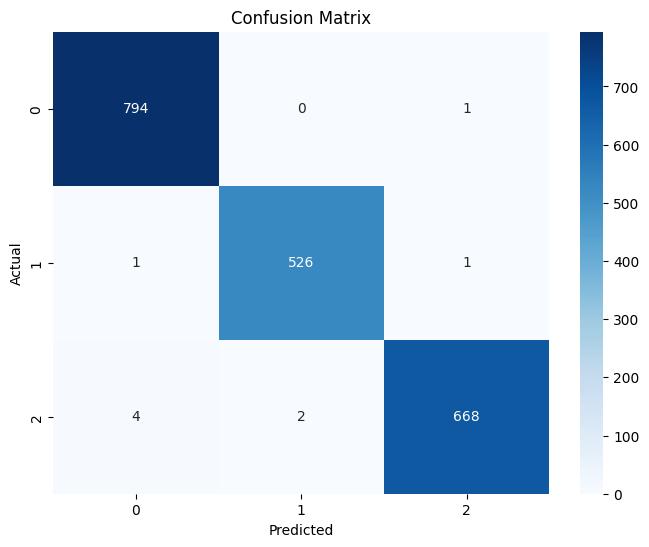

In [6]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## KMeans Clustering (Unsupervised)

In [8]:
from sklearn.cluster import KMeans

num_clusters = len(np.unique(y))  # عدد الكلاسات

kmeans = KMeans(num_clusters, n_init=100, random_state=42)

kmeans.fit(X_flat)

cluster_labels = kmeans.labels_

# توزيع الصور على clusters
for i in range(num_clusters):
    print(f"Cluster {i} has {np.sum(cluster_labels == i)} images")

Cluster 0 has 793 images
Cluster 1 has 3088 images
Cluster 2 has 4105 images


KMeans Accuracy: 0.5351865765088906


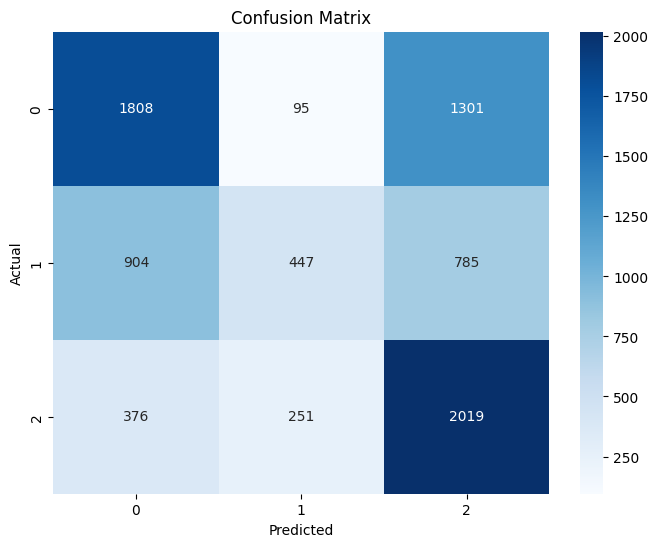

In [12]:
from sklearn.metrics import accuracy_score
from scipy.optimize import linear_sum_assignment

import numpy as np

# 1- حساب confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, cluster_labels)

# 2- إيجاد أفضل توافق بين clusters و labels

row, col = linear_sum_assignment(-cm)  # سالب لأن linear_sum_assignment تبحث عن أقل قيمة
mapping = dict(zip(col, row))

# 3- تحويل cluster labels للأرقام المقابلة للـ true labels
new_labels = np.array([mapping[label] for label in cluster_labels])


cm_final = confusion_matrix(y, new_labels)

# 4- حساب accuracy
acc = accuracy_score(y, new_labels)
print("KMeans Accuracy:", acc)


plt.figure(figsize=(8,6))
sns.heatmap(cm_final, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
